In [1]:
!python --version

Python 3.9.13


In [2]:
! pip install transformers==4.25.1 TorchCRF==1.1.0 pretty-confusion-matrix

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 22.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 128.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 1.5 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 37.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 14.4 MB/s eta 0:00:00


# Lib

In [3]:
import os
import logging
import datetime
import pandas as pd
import numpy as np
import argparse
import pickle
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertModel
from transformers.optimization import get_cosine_schedule_with_warmup, AdamW
from TorchCRF import CRF
import seaborn as sn
import matplotlib.pyplot as plt
from pretty_confusion_matrix import pp_matrix

import warnings
warnings.filterwarnings('ignore')

# Config

In [20]:
def get_config(args=None):
    parser = argparse.ArgumentParser(
        description="UTH-BERT_CRF_Training")
    
    parser.add_argument('--bert_model_path', type=str, default='UTH_BERT/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K')
    parser.add_argument('--output_path', type=str, default="")
    parser.add_argument('--input_data_path', type=str, default="data")    
    parser.add_argument('--input_data', type=str, default="df_row_token_classification_dataset.pkl")
    parser.add_argument('--device', default = "cuda" if torch.cuda.is_available() else "cpu", type=str)
    
    parser.add_argument('--label_num',default=3, type=int)        
    parser.add_argument('--batch_size', default=32, type=int)    
    parser.add_argument('--epoch_num', default=10, type=int)    
    parser.add_argument('--learning_rate', default=3e-5, type=float)
    parser.add_argument('--weight_decay', default=0.01, type=float)
    parser.add_argument('--clip_grad', default=5, type=int)  
    parser.add_argument('--last_hidden_state_dropout_prob', default=0.2, type=float)
    parser.add_argument('--hidden_size', default=768, type=int) 
    

    config = parser.parse_args(args=[])

    config.device = torch.device(config.device)

    return config

#  Input data

In [3]:
def get_encoding(df):
    encoding={}
    encoding['input_ids']=df['input_ids'].tolist()
    #encoding['token_type_ids']=df['token_type_ids'].tolist()
    encoding['attention_mask']=df['attention_mask'].tolist() 
    return encoding

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, config):
        self.encodings = encodings
        self.labels = labels
        self.config = config
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(self.config.device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).to(self.config.device)
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
def collate_func(batch):
    input_ids, attention_mask,labels = [], [], []
    
    for mini_batch in batch:
        input_ids.append(mini_batch['input_ids'])
        attention_mask.append(mini_batch['attention_mask'])
        labels.append(mini_batch['labels'])
        
    item={}
    item['input_ids'] =pad_sequence(input_ids, batch_first=True, padding_value=0)
    item['attention_mask'] = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    item['labels'] =pad_sequence(labels, batch_first=True, padding_value=-100)
    
    return item

# BERT_CRF model

In [22]:
class BERT_CRF_NER(torch.nn.Module):
    
    def __init__(self,config):#,config, bert_model
        super(BERT_CRF_NER, self).__init__()
        self.num_labels = config.label_num
        #self.bert = bert_model
        self.bert =BertModel.from_pretrained(config.bert_model_path, num_labels=config.label_num).to(config.device)
        self.dropout = torch.nn.Dropout(config.last_hidden_state_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, config.label_num)
        self.crf = CRF(self.num_labels)
        
    def forward(self,input_ids, attention_mask ,token_type_ids=None, label=None):
        
        # get output from bert and the output will be fed into crf layer as emission
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output) #(batch_size, sequence_size, num_labels)
        outputs = (logits,)
        
        # crf layer
        if label is not None:
            # crf input label & label_mask [CLS],[SEP] [PAD]==>0 others==>1
            zero = torch.zeros_like(label)
            one=torch.ones_like(label)
            label_ = torch.where(label ==-100, zero, label) # (batch_size. sequence_size)
            mask_ = torch.where(label >=0, one, label)
            mask_ = torch.where(label ==-100, zero, mask_).to(device=config.device, dtype=torch.uint8)# (batch_size. sequence_size)
            
            # get crf loss
            loss=self.crf.forward(logits[:,1:,:], label_[:,1:], mask_[:,1:]).sum(dim=0)* (-1)
            #loss=crf.forward(logits, label_, mask_).sum(dim=0)* (-1)
            loss/=logits.size()[0]
            outputs = (loss,) + outputs
        
        return outputs # contain: (loss), scores

# Train

In [8]:
def train_epoch(model, config, epoch_idx, training_dataloader, optimizer,scheduler):
    
    # model ==> train mode
    model.train()
    train_losses = 0
    for batch_id, batch in enumerate(tqdm(training_dataloader)):    

        input_ids, attention_mask, label=batch['input_ids'], batch['attention_mask'], batch['labels']
              
        # forward pass
        loss=model(input_ids,attention_mask,label=label)[0]
        train_losses += loss.item()      
        
        # grad update      
        model.zero_grad()
        loss.backward()
        
        # clip_grad
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=config.clip_grad)
        
        # grad calculate
        optimizer.step()
        scheduler.step()
        
    train_loss = float(train_losses) / len(training_dataloader)
    logging.info(f"Epoch: {epoch_idx}, train loss: {train_loss}")
    print(f"Epoch: {epoch_idx}, train loss: {train_loss}")

In [9]:
def train(model,training_dataloader,validation_dataloader,optimizer,scheduler,config):
    
    best_val_f1 = 0.0
    
    for epoch_idx in range(1, config.epoch_num + 1):    
        print("epoch {}/{}".format(epoch_idx, config.epoch_num))
        
        # Train
        train_epoch(model, config, epoch_idx, training_dataloader, optimizer,scheduler)

        # Validate
        print('Validate')
        logging.info("Start validation")
        val_metrics=validate(model,validation_dataloader)
        val_f1 = val_metrics['F1_B']+val_metrics['F1_I']+val_metrics['F1_B+I']
        
        # save model with highest F1 score
        if val_f1>best_val_f1:

            best_val_f1=val_f1
        
            torch.save(model, os.path.join(config.output_model_path,
                                                    "model_{}.pt".format(run_id)))
            logging.info("--------Save best model--------")
            
    logging.info("Training Finished")    
    print("Training Finished")

In [10]:
def validate(model,validation_dataloader):
    
    # model ==> eval mode
    model.eval()
    val_losses = 0
    
    true_labels=[]
    pred_labels=[]
    
    for batch_id, batch in enumerate(tqdm(validation_dataloader)):    
        
        input_ids, attention_mask, label=batch['input_ids'], batch['attention_mask'], batch['labels']
        
        with torch.no_grad():
            loss=model(input_ids,attention_mask,label=label)[0]
            val_losses += loss.item()
            
            # output emission matrix 
            batch_output = model(input_ids,attention_mask)[0]
            
            # label_mask for crf ,[CLS],[SEP] [PAD]==>0 others==>1
            zero = torch.zeros_like(label)
            one=torch.ones_like(label)
            mask_ = torch.where(label >=0, one, label)
            mask_ = torch.where(label ==-100, zero, mask_).to(device=config.device, dtype=torch.uint8)
            
            # output predict-label sequence
            pred_label=model.crf.viterbi_decode(batch_output[:,1:,:], mask=mask_[:,1:])
            
            # remove ground_ture label's[CLS][SEP][PAD]=-100 ==>get label's length that is as same as predict-label's length
            true_label=[]
            label=label.cpu().numpy()
            for i in range(len(label)):
                #true_label.append(label[i][~np.isin(label[i], -100)].to('cpu').numpy().tolist())
                true_label.append(label[i][~np.isin(label[i], -100)].tolist())
                
            true_labels.extend(true_label)
            pred_labels.extend(pred_label)         
            
    assert len(pred_labels) == len(true_labels)        
    
    flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
    true_labels_flatten=flatten(true_labels)
    pred_labels_flatten=flatten(pred_labels)
    #print("true_label",true_labels_)
    #print("pred_label",pred_labels_)
    metrics={}
    f1_B,f1_I,f1_B_I = compute_metrics(true_labels_flatten,pred_labels_flatten)
    metrics['F1_B'],metrics['F1_I'],metrics['F1_B+I']=f1_B,f1_I,f1_B_I
    metrics['loss']=float(val_losses) / len(validation_dataloader)
    
    return metrics

In [11]:
def compute_metrics(true_labels_flatten,pred_labels_flatten):
    
    print(classification_report(true_labels_flatten, pred_labels_flatten, target_names=['O', 'B', 'I']))
    logging.info(classification_report(true_labels_flatten, pred_labels_flatten, target_names=['O', 'B', 'I']))
    
    #plot confusion matrix
    c=confusion_matrix(true_labels_flatten,pred_labels_flatten)
    df_c=pd.DataFrame(c,index=[i for i in ['O','B','I']],columns=[i for i in ['O','B','I']])
    pp_matrix(df_c,figsize=(4,4),cmap='PuRd')
    #f1
    f1_B=precision_recall_fscore_support(true_labels_flatten, pred_labels_flatten)[2][1]
    f1_I=precision_recall_fscore_support(true_labels_flatten, pred_labels_flatten)[2][2]
    
    # If B and I are considered the same
    true_labels_flatten_=[1 if true_labels_flatten[i]==2 else true_labels_flatten[i] for i in range(len(true_labels_flatten))]
    pred_labels_flatten_=[1 if pred_labels_flatten[i]==2 else pred_labels_flatten[i] for i in range(len(pred_labels_flatten))]
    
    print(classification_report(true_labels_flatten_, pred_labels_flatten_, target_names=['O', 'B+I']))
    logging.info(classification_report(true_labels_flatten_, pred_labels_flatten_, target_names=['O', 'B+I']))
    
    #plot confusion matrix
    c_=confusion_matrix(true_labels_flatten_,pred_labels_flatten_)
    df_c_=pd.DataFrame(c_,index=[i for i in ['O','B+I']],columns=[i for i in ['O','B+I']])
    pp_matrix(df_c_,figsize=(4,4),cmap='PuRd')#    
    #f1
    f1_B_I=precision_recall_fscore_support(true_labels_flatten_, pred_labels_flatten_)[2][1]
    
    return f1_B,f1_I,f1_B_I

# Main

Some weights of the model checkpoint at UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch 1/10


100%|██████████| 189/189 [01:59<00:00,  1.59it/s]


Epoch: 1, train loss: 6.075846178821786
Validate


100%|██████████| 48/48 [00:13<00:00,  3.48it/s]


              precision    recall  f1-score   support

           O       0.96      0.99      0.98     31723
           B       0.90      0.81      0.85      2192
           I       0.86      0.65      0.74      2377

    accuracy                           0.96     36292
   macro avg       0.91      0.82      0.86     36292
weighted avg       0.95      0.96      0.95     36292



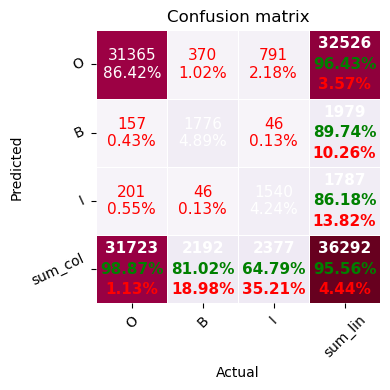

              precision    recall  f1-score   support

           O       0.96      0.99      0.98     31723
         B+I       0.90      0.75      0.82      4569

    accuracy                           0.96     36292
   macro avg       0.93      0.87      0.90     36292
weighted avg       0.96      0.96      0.96     36292



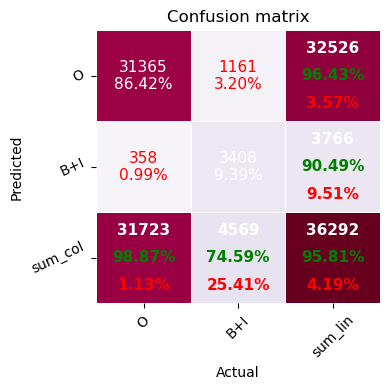

epoch 2/10


100%|██████████| 189/189 [01:28<00:00,  2.14it/s]


Epoch: 2, train loss: 2.549656480393082
Validate


100%|██████████| 48/48 [00:14<00:00,  3.25it/s]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
           B       0.89      0.86      0.87      2192
           I       0.82      0.79      0.81      2377

    accuracy                           0.96     36292
   macro avg       0.90      0.88      0.89     36292
weighted avg       0.96      0.96      0.96     36292



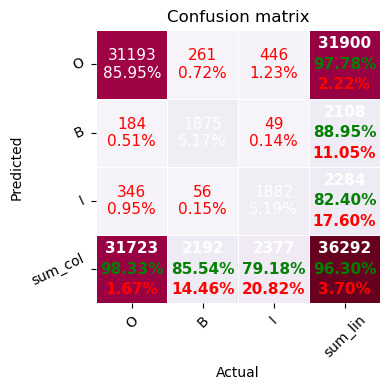

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
         B+I       0.88      0.85      0.86      4569

    accuracy                           0.97     36292
   macro avg       0.93      0.91      0.92     36292
weighted avg       0.97      0.97      0.97     36292



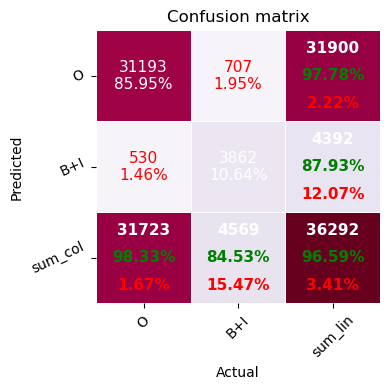

epoch 3/10


100%|██████████| 189/189 [01:23<00:00,  2.26it/s]


Epoch: 3, train loss: 1.5218809978671806
Validate


100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
           B       0.88      0.87      0.87      2192
           I       0.83      0.81      0.82      2377

    accuracy                           0.96     36292
   macro avg       0.90      0.89      0.89     36292
weighted avg       0.96      0.96      0.96     36292



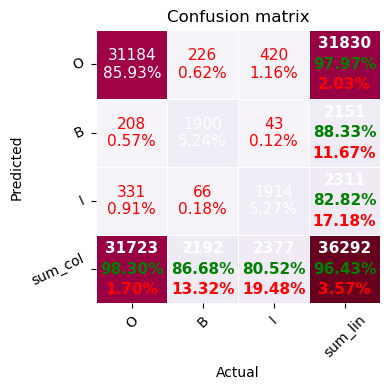

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
         B+I       0.88      0.86      0.87      4569

    accuracy                           0.97     36292
   macro avg       0.93      0.92      0.93     36292
weighted avg       0.97      0.97      0.97     36292



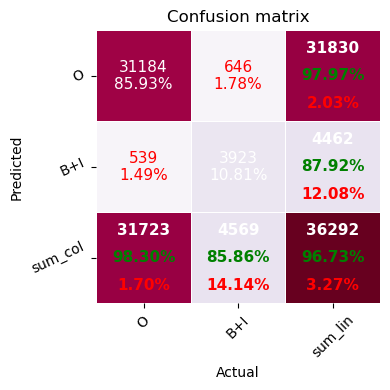

epoch 4/10


100%|██████████| 189/189 [01:22<00:00,  2.29it/s]


Epoch: 4, train loss: 0.9849849890464197
Validate


100%|██████████| 48/48 [00:13<00:00,  3.63it/s]


              precision    recall  f1-score   support

           O       0.98      0.99      0.98     31723
           B       0.88      0.89      0.88      2192
           I       0.86      0.78      0.82      2377

    accuracy                           0.97     36292
   macro avg       0.91      0.88      0.90     36292
weighted avg       0.97      0.97      0.97     36292



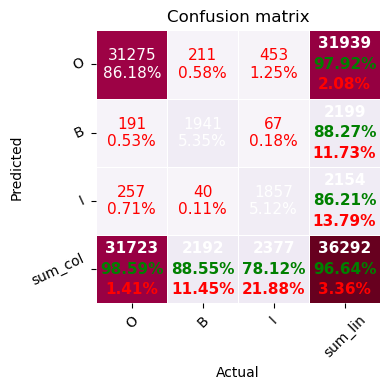

              precision    recall  f1-score   support

           O       0.98      0.99      0.98     31723
         B+I       0.90      0.85      0.88      4569

    accuracy                           0.97     36292
   macro avg       0.94      0.92      0.93     36292
weighted avg       0.97      0.97      0.97     36292



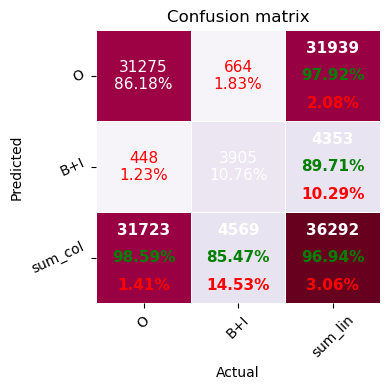

epoch 5/10


100%|██████████| 189/189 [01:22<00:00,  2.29it/s]


Epoch: 5, train loss: 0.5783280291096874
Validate


100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


              precision    recall  f1-score   support

           O       0.99      0.98      0.98     31723
           B       0.87      0.89      0.88      2192
           I       0.77      0.86      0.81      2377

    accuracy                           0.96     36292
   macro avg       0.88      0.91      0.89     36292
weighted avg       0.96      0.96      0.96     36292



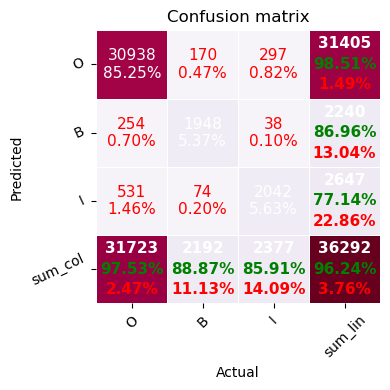

              precision    recall  f1-score   support

           O       0.99      0.98      0.98     31723
         B+I       0.84      0.90      0.87      4569

    accuracy                           0.97     36292
   macro avg       0.91      0.94      0.92     36292
weighted avg       0.97      0.97      0.97     36292



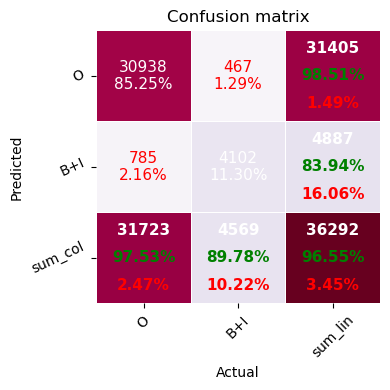

epoch 6/10


100%|██████████| 189/189 [01:26<00:00,  2.17it/s]


Epoch: 6, train loss: 0.38839898222968694
Validate


100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
           B       0.87      0.89      0.88      2192
           I       0.83      0.83      0.83      2377

    accuracy                           0.97     36292
   macro avg       0.89      0.90      0.90     36292
weighted avg       0.97      0.97      0.97     36292



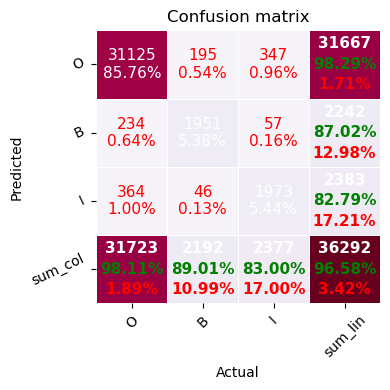

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
         B+I       0.87      0.88      0.88      4569

    accuracy                           0.97     36292
   macro avg       0.93      0.93      0.93     36292
weighted avg       0.97      0.97      0.97     36292



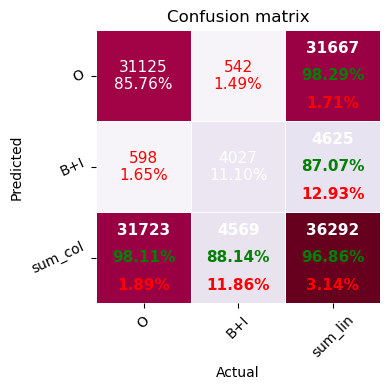

epoch 7/10


100%|██████████| 189/189 [01:28<00:00,  2.13it/s]


Epoch: 7, train loss: 0.23450535330822858
Validate


100%|██████████| 48/48 [00:14<00:00,  3.34it/s]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
           B       0.88      0.89      0.88      2192
           I       0.81      0.83      0.82      2377

    accuracy                           0.97     36292
   macro avg       0.89      0.90      0.90     36292
weighted avg       0.97      0.97      0.97     36292



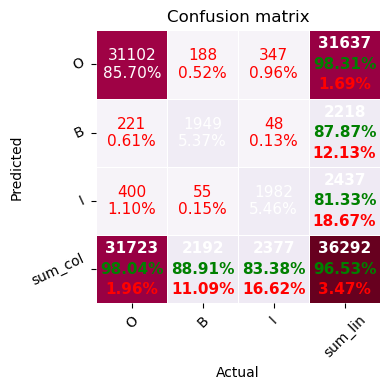

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
         B+I       0.87      0.88      0.87      4569

    accuracy                           0.97     36292
   macro avg       0.92      0.93      0.93     36292
weighted avg       0.97      0.97      0.97     36292



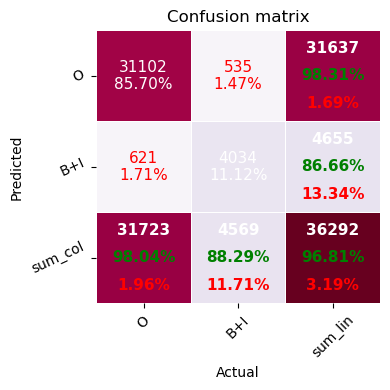

epoch 8/10


100%|██████████| 189/189 [01:28<00:00,  2.14it/s]


Epoch: 8, train loss: 0.14994109563391517
Validate


100%|██████████| 48/48 [00:14<00:00,  3.31it/s]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
           B       0.88      0.89      0.88      2192
           I       0.83      0.81      0.82      2377

    accuracy                           0.97     36292
   macro avg       0.90      0.89      0.90     36292
weighted avg       0.97      0.97      0.97     36292



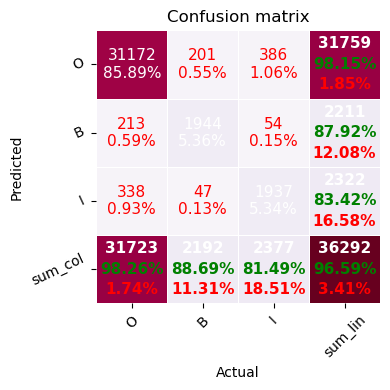

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
         B+I       0.88      0.87      0.87      4569

    accuracy                           0.97     36292
   macro avg       0.93      0.93      0.93     36292
weighted avg       0.97      0.97      0.97     36292



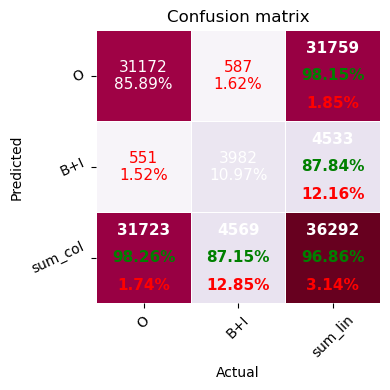

epoch 9/10


100%|██████████| 189/189 [01:28<00:00,  2.13it/s]


Epoch: 9, train loss: 0.10885592134639857
Validate


100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
           B       0.88      0.89      0.88      2192
           I       0.83      0.82      0.82      2377

    accuracy                           0.97     36292
   macro avg       0.90      0.89      0.90     36292
weighted avg       0.97      0.97      0.97     36292



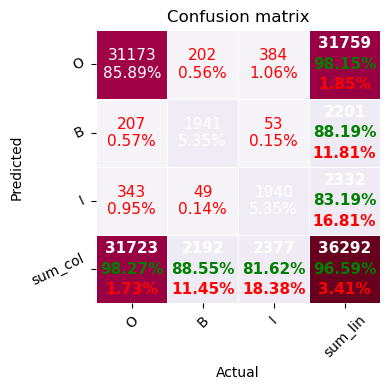

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
         B+I       0.88      0.87      0.88      4569

    accuracy                           0.97     36292
   macro avg       0.93      0.93      0.93     36292
weighted avg       0.97      0.97      0.97     36292



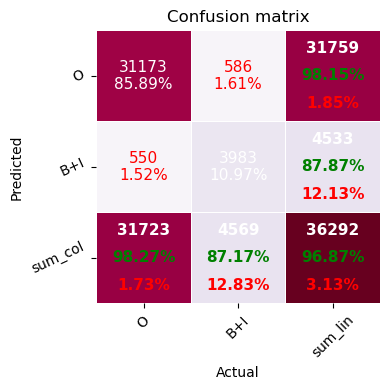

epoch 10/10


100%|██████████| 189/189 [01:25<00:00,  2.22it/s]


Epoch: 10, train loss: 0.09590649559463142
Validate


100%|██████████| 48/48 [00:12<00:00,  3.78it/s]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
           B       0.88      0.89      0.88      2192
           I       0.83      0.81      0.82      2377

    accuracy                           0.97     36292
   macro avg       0.90      0.89      0.90     36292
weighted avg       0.97      0.97      0.97     36292



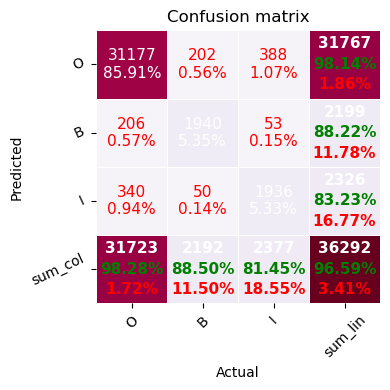

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
         B+I       0.88      0.87      0.88      4569

    accuracy                           0.97     36292
   macro avg       0.93      0.93      0.93     36292
weighted avg       0.97      0.97      0.97     36292



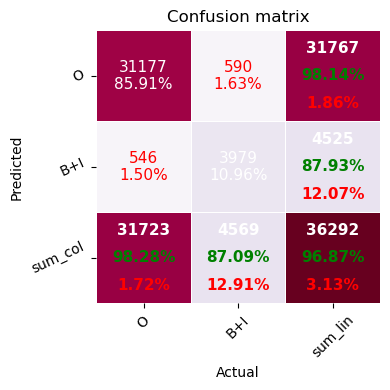

Training Finished


In [13]:
if __name__ == "__main__":
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    # Config
    config = get_config()  
    
    # Log & output path
    now = datetime.datetime.now()
    run_id = np.random.randint(10000, 99999)
    if config.output_path == "":
        config.output_path = os.getcwd()
    config.output_path = os.path.join(config.output_path, "results", "run_" + str(now.year) + "." + str(now.month) + "." + str(now.day) + "_" + str(run_id))
    
    os.makedirs(os.path.join(config.output_path, "model"))
    config.output_model_path=os.path.join(config.output_path, "model")
    
    logging.basicConfig(
        filename=os.path.join(config.output_path, "log_" + str(run_id) + ".txt"), 
        filemode='w',
        level=logging.INFO, 
        format='[%(levelname)s]%(message)s', force=True)
    
    # Load data
    """
    with open(os.path.join(config.input_data_path, config.input_data), 'rb') as file:
        df=pickle.load(file)
        
    train_df,test_df = train_test_split(df, test_size=0.2, random_state=1)    
    
    with open(os.path.join(config.input_data_path,'test_df.pkl'), 'wb') as file:
        pickle.dump(train_df, file)
    with open(os.path.join(config.input_data_path,'test_df.pkl'), 'wb') as file:
        pickle.dump(test_df, file)     
    """
    with open(os.path.join(config.input_data_path, 'train_df.pkl'), 'rb') as file:
        train_df=pickle.load(file)
    with open(os.path.join(config.input_data_path,'test_df.pkl'), 'rb') as file:
        test_df=pickle.load(file)
        
    train_encodings, valid_encodings=get_encoding(train_df), get_encoding(test_df)
    train_labels, valid_labels = train_df['labels'].tolist(),test_df['labels'].tolist()
    
    training_dataset = Dataset(train_encodings, train_labels, config)
    validation_dataset = Dataset(valid_encodings, valid_labels, config)    
    
    training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, num_workers=0, shuffle=True,collate_fn=collate_func,generator=torch.Generator(device = config.device))
    validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size, num_workers=0, shuffle=True,collate_fn=collate_func,generator=torch.Generator(device = config.device)) 
    
    # Model
    BERT_CRFModel = BERT_CRF_NER(config).to(config.device)
    
    # Prepare optimizer    full_fine_tuning
    bert_optimizer = list(BERT_CRFModel.bert.named_parameters())
    classifier_optimizer = list(BERT_CRFModel.classifier.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in bert_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': config.weight_decay},
        {'params': [p for n, p in bert_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0},
        {'params': [p for n, p in classifier_optimizer if not any(nd in n for nd in no_decay)],
         'lr': config.learning_rate * 5, 'weight_decay': config.weight_decay},
        {'params': [p for n, p in classifier_optimizer if any(nd in n for nd in no_decay)],
         'lr': config.learning_rate * 5, 'weight_decay': 0.0},
        {'params': BERT_CRFModel.crf.parameters(), 'lr': config.learning_rate * 5}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, correct_bias=False)
    
    # Dynamic learning rate adjustment
    train_steps_per_epoch = len(training_dataset) // config.batch_size
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=(config.epoch_num // 10) * train_steps_per_epoch, 
                                                num_training_steps=config.epoch_num * train_steps_per_epoch)
    #Train the model
    logging.info("--------Start Training--------")
    train(BERT_CRFModel,training_dataloader,validation_dataloader,optimizer,scheduler,config)
    

# Evaluation

In [23]:
config = get_config() 
#config.device='cpu' 
# load model
BERT_CRFModel=torch.load('results/run_2023.1.27_40578/model/model_40578.pt')
BERT_CRFModel.to(config.device)
print()

In [18]:
# load data
with open(os.path.join(config.input_data_path,'test_df.pkl'), 'rb') as file:
    test_df=pickle.load(file)
valid_encodings= get_encoding(test_df)
valid_labels = test_df['labels'].tolist()
validation_dataset = Dataset(valid_encodings, valid_labels, config)    
#validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size, num_workers=0, shuffle=True,generator=torch.Generator(device = config.device))
validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size, num_workers=0, shuffle=False,collate_fn=collate_func,) 

In [19]:
def inference(model,validation_dataloader):
    
    # model ==> eval mode
    model.eval()
    val_losses = 0
    
    true_labels=[]
    pred_labels=[]
    
    for batch_id, batch in enumerate(tqdm(validation_dataloader)):    
        
        input_ids, attention_mask, label=batch['input_ids'], batch['attention_mask'], batch['labels']
        
        with torch.no_grad():

            # output emission matrix 
            batch_output = model(input_ids,attention_mask)[0]
            
            # label_mask for crf ,[CLS],[SEP] [PAD]==>0 others==>1
            zero = torch.zeros_like(label)
            one=torch.ones_like(label)
            mask_ = torch.where(label >=0, one, label)
            mask_ = torch.where(label ==-100, zero, mask_).to(device=config.device, dtype=torch.uint8)
            
            # output predict-label sequence
            pred_label=model.crf.viterbi_decode(batch_output[:,1:,:], mask=mask_[:,1:])
            
            # remove ground_ture label's[CLS][SEP][PAD]=-100 ==>get label's length that is as same as predict-label's length
            true_label=[]
            label=label.cpu().numpy()
            for i in range(len(label)):
                #true_label.append(label[i][~np.isin(label[i], -100)].to('cpu').numpy().tolist())
                true_label.append(label[i][~np.isin(label[i], -100)].tolist())
                
            true_labels.extend(true_label)
            pred_labels.extend(pred_label)         
            
    assert len(pred_labels) == len(true_labels)        
    
    return true_labels,pred_labels

In [20]:
true_labels,pred_labels=inference(BERT_CRFModel,validation_dataloader)

100%|██████████| 48/48 [00:06<00:00,  7.37it/s]


In [21]:
# flatten all results
flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
true_labels_flatten=flatten(true_labels)
pred_labels_flatten=flatten(pred_labels)

print(classification_report(true_labels_flatten, pred_labels_flatten, target_names=['O', 'B', 'I']))

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
           B       0.87      0.89      0.88      2192
           I       0.83      0.83      0.83      2377

    accuracy                           0.97     36292
   macro avg       0.89      0.90      0.90     36292
weighted avg       0.97      0.97      0.97     36292



In [22]:
# consider B and I the same
true_labels_flatten_=[1 if true_labels_flatten[i]==2 else true_labels_flatten[i] for i in range(len(true_labels_flatten))]
pred_labels_flatten_=[1 if pred_labels_flatten[i]==2 else pred_labels_flatten[i] for i in range(len(pred_labels_flatten))]

print(classification_report(true_labels_flatten_, pred_labels_flatten_, target_names=['O', 'B+I']))

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31723
         B+I       0.87      0.88      0.88      4569

    accuracy                           0.97     36292
   macro avg       0.93      0.93      0.93     36292
weighted avg       0.97      0.97      0.97     36292

